In [ ]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
	print(os.getcwd())
except:
	pass


In [4]:
from utils.load_mnist_1 import *

import numpy as np


In [5]:
# import ResNet and configure it 
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Activation, Flatten, MaxPool2D, BatchNormalization, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam, Adadelta
from keras.applications import ResNet50
from keras.applications import resnet50 as resnet50
from keras.preprocessing import image
from keras.models import Model 
from keras.utils import to_categorical
from keras.regularizers import l2


/data/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
print("loaded data set from mnist_1 method")


loaded data set from mnist_1 method


In [7]:
def resnet_transfer_preparedata(kind='train', no=0): 
    import skimage.transform

    imgs, lbls = [], []

    if kind == 'train': 
        imgs, lbls = load_images_train_32_32_rgb()
    elif kind == "test": 
        imgs, lbls = load_images_test_32_32_rgb()


    if no != 0: 
        imgs = imgs[:no]
        lbls = lbls[:no]

    imgs_resize = []
    no_images = len(imgs)
    status_print = "resizing {} / " +  str(no_images)
    print(status_print.format(0), end="\r")

    for i in range(len(imgs)): 
        img = skimage.transform.resize(
            imgs[i], 
            (38,38),
            mode ='constant')
        imgs_resize.append(img)
        if i % 500 == 0: 
            print(status_print.format(i), end="\r")

    imgs_resize = np.array(imgs_resize)
    print("resizing complete: " + str(imgs_resize.shape))

    lbls_str = image_class_to_str(lbls)
    return imgs_resize, lbls, lbls_str


In [8]:
train_images, train_labels, train_labels_str = resnet_transfer_preparedata(no=1000)
test_images, test_labels, test_labels_str = resnet_transfer_preparedata('test', no=250)

train_labels_cat = to_categorical(train_labels, num_classes=10)
test_labels_cat = to_categorical(test_labels, num_classes=10)


resizing complete: (1000, 38, 38, 3)
resizing complete: (250, 38, 38, 3)


In [9]:


base_model = ResNet50(
    include_top = False, 
    weights = 'imagenet', 
    input_shape = [38,38,3]
)


Instructions for updating:
Colocations handled automatically by placer.


/data/anaconda/envs/py35/lib/python3.5/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [10]:
# for l in base_model.layers[:-2]: 
#     l.trainable = False


In [11]:
base_model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 38, 38, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 44, 44, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 19, 19, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 19, 19, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [12]:

added_layers = base_model.output 

# Prior to GAP, one would flatten your tensor and then add a few fully connected layers in your model. 
# The problem is that a bunch of parameters in your model end up being attributed to the dense layers and 
# could potentially lead to overfitting. A natural solution was to add dropout to help regulate that.

# However a few years ago, the idea of having a Global Average Pooling came into play. 
# GAP can be viewed as alternative to the whole flatten FC Dropout paradigm. GAP helps prevent overfitting 
# by doing an extreme form of reduction. Given a H X W X D tensor, GAP will average the H X W features 
# into a single number and reduce the tensor into a 1 X 1 X D tensor.

# The original paper simply applied GAP and then a softmax. However, it's now common to have GAP followed by a FC layer.


added_layers = GlobalAveragePooling2D()(added_layers)#  Flatten()(added_layers)
added_layers = Dropout(0.7)(added_layers)

# initial run was showing very high variance (acc on trainng is good, but acc on val is very poor)
# so i added regulisation 
added_layers = Dense(128, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(added_layers)
added_layers = Activation('relu')(added_layers)
# added_layers = BatchNormalization()(added_layers)

preds = Dense(10, activation ='softmax')(added_layers)

final_model = Model(input = base_model.input, outputs=preds)

final_model.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 38, 38, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 44, 44, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 19, 19, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 19, 19, 64)   256         conv1[0][0]                 

/data/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:28: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`


In [13]:
adam = Adam(lr=0.0001)
final_model.compile(optimizer= Adadelta(), loss='categorical_crossentropy', metrics=['accuracy'])


In [14]:
train_images = train_images[:1000]
train_labels_cat = train_labels_cat[:1000]

test_images = test_images[:250]
test_labels_cat = test_labels_cat[:250]

print(train_images.shape)
print(test_images.shape)
print(train_labels_cat.shape)
print(test_labels_cat.shape)

print(np.max(train_images), np.min(train_images))
print(np.max(test_images), np.min(test_images))

(1000, 38, 38, 3)
(250, 38, 38, 3)
(1000, 10)
(250, 10)
1.0 0.0
0.9998424854706426 0.0


In [15]:
history = final_model.fit(
    train_images, train_labels_cat, 
    validation_data= (test_images, test_labels_cat ), 
    epochs = 15, batch_size = 100)


Instructions for updating:
Use tf.cast instead.
Train on 1000 samples, validate on 250 samples
Epoch 1/15
1000/1000 [==============================] - 19s 19ms/step - loss: 4.2504 - acc: 0.5020 - val_loss: 3.1745 - val_acc: 0.7880
Epoch 2/15
1000/1000 [==============================] - 4s 4ms/step - loss: 2.8669 - acc: 0.8040 - val_loss: 3.0200 - val_acc: 0.7640
Epoch 3/15
1000/1000 [==============================] - 4s 4ms/step - loss: 2.4866 - acc: 0.8660 - val_loss: 2.5867 - val_acc: 0.8320
Epoch 4/15
1000/1000 [==============================] - 4s 4ms/step - loss: 2.2414 - acc: 0.9060 - val_loss: 2.6375 - val_acc: 0.8320
Epoch 5/15
1000/1000 [==============================] - 4s 4ms/step - loss: 2.0053 - acc: 0.9380 - val_loss: 2.5853 - val_acc: 0.8400
Epoch 6/15
1000/1000 [==============================] - 4s 4ms/step - loss: 2.0534 - acc: 0.8990 - val_loss: 2.4618 - val_acc: 0.8280
Epoch 7/15
1000/1000 [==============================] - 4s 4ms/step - loss: 1.7218 - acc: 0.9510 - 

In [16]:
# We can get our score
score = final_model.evaluate(test_images, test_labels_cat, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])


Test loss: 1.6315122146606444
Test accuracy: 0.8280000014305114


dict_keys(['acc', 'val_loss', 'val_acc', 'loss'])


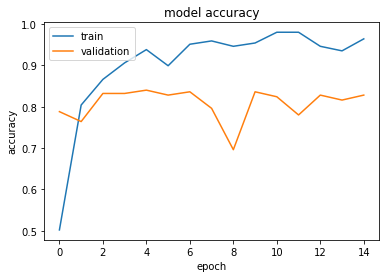

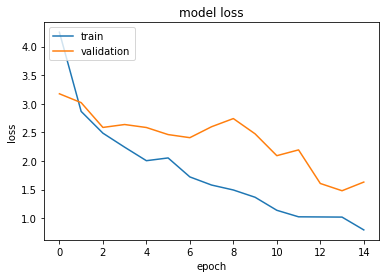

In [17]:
# https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()



In [82]:
# We can get our score
score = final_model.evaluate(test_images, test_labels_cat, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])


Test loss: 1.6315122146606444
Test accuracy: 0.8280000014305114


[3.2835639e-09 9.9999976e-01 5.1571476e-09 1.0503337e-08 1.7229203e-07
 2.0843756e-09 1.9444422e-09 5.8324892e-09 3.0865239e-09 2.2709223e-08]
        labels  pred  class
0  t_shirt_top   0.0  False
1      trouser   1.0   True
2     pullover   0.0  False
3        dress   0.0  False
4         coat   0.0  False
5       sandal   0.0  False
6        shirt   0.0  False
7      sneaker   0.0  False
8          bag   0.0  False
9  ankle_boots   0.0  False


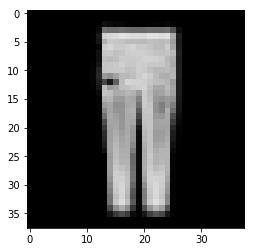

In [84]:

img = test_images[200]

imgs_in =[]
imgs_in.append(img)
imgs_in = np.array(imgs_in)
pred_output = final_model.predict(imgs_in).squeeze()
print(pred_output)
labels=['t_shirt_top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle_boots']


import pandas as pd

outputs = pd.DataFrame(
    data = {
        "pred" : np.round(pred_output,6), 
        "labels" : labels
    } )

# print(outputs)

outputs['class'] = outputs.pred > .5

print(outputs)

plt.imshow(img)
plt.show()